# Model definition

## Settings

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import helpers.settings as sts
sts.print_settings(sts)

BEST_ESTIMATOR_FILENAME : best_estimator_0.0.1.pkl
DATASET_TRAIN_FILENAME : dataset_train.parquet
DATASET_VALIDATION_FILENAME : dataset_validation.parquet
ETL_VERSION : 0.0.1
MODEL_FILENAME : model.pkl
MODEL_VERSION : 0.0.1
PREPROCESSOR_FILENAME : preprocessor_0.0.1.pkl
TRAINED_BEST_ESTIMATOR_FILENAME : trained_best_estimator_0.0.1.pkl
color : <class 'helpers.settings.color'>
print_settings : <function print_settings at 0x7fe8d7aaec10>



## Imports

In [4]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    plot_precision_recall_curve,
    precision_recall_curve,
    average_precision_score,
    plot_confusion_matrix,
)
import re
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import shap
import matplotlib.pyplot as plt  
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

##  Load dataset

In [5]:
df_train = pd.read_parquet(f"data/{sts.DATASET_TRAIN_FILENAME}")

In [6]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

## Load preprocessor

In [7]:
with open(f"artifacts/{sts.PREPROCESSOR_FILENAME}","rb") as file:
    preprocessor = pickle.load(file)

## Model testing

### Deep Learning

In [8]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(curve='PR')])
    return model

In [9]:
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=20, verbose=1)

In [10]:
clf_deep_learning = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("imputer", SimpleImputer(fill_value=0)),
        ("scaler", StandardScaler()),
        ("clf", model),
    ]
)

In [11]:
clf_deep_learning.fit(X_train, y_train)

Epoch 1/6
1550/1550 [==============================] - 1s 545us/step - loss: 0.1416 - auc: 0.0153
Epoch 2/6
1550/1550 [==============================] - 1s 530us/step - loss: 0.0684 - auc: 0.0326
Epoch 3/6
1550/1550 [==============================] - 1s 528us/step - loss: 0.0660 - auc: 0.0624
Epoch 4/6
1550/1550 [==============================] - 1s 544us/step - loss: 0.0643 - auc: 0.0692
Epoch 5/6
1550/1550 [==============================] - 1s 554us/step - loss: 0.0632 - auc: 0.0794
Epoch 6/6
1550/1550 [==============================] - 1s 534us/step - loss: 0.0624 - auc: 0.0874


Pipeline(steps=[('preprocessor',
                 ModifiedColumnTransformer(categorical_features=['CODE_GENDER',
                                                                 'FLAG_OWN_CAR',
                                                                 'FLAG_OWN_REALTY',
                                                                 'NAME_INCOME_TYPE',
                                                                 'NAME_EDUCATION_TYPE',
                                                                 'NAME_FAMILY_STATUS',
                                                                 'NAME_HOUSING_TYPE',
                                                                 'FLAG_MOBIL',
                                                                 'FLAG_WORK_PHONE',
                                                                 'FLAG_PHONE',
                                                                 'FLAG_EMAIL'],
                                           numeric_fea

In [12]:
y_proba = clf_deep_learning.predict_proba(X_train)[:,1]
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [13]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30584
           1       1.00      0.04      0.07       404

    accuracy                           0.99     30988
   macro avg       0.99      0.52      0.53     30988
weighted avg       0.99      0.99      0.98     30988



### Others

In [14]:
estimators = [
    {
        "clf": [XGBClassifier()],
    },
    {
        "clf": [LGBMClassifier()],
    },
    {
        "clf": [SVC()],
    },
    {
        "clf": [RandomForestClassifier()],
    },
    {
        "clf": [AdaBoostClassifier()],
    },
]

In [15]:
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("clf", XGBClassifier()),
    ],
)

In [16]:
gs = GridSearchCV(
    clf,
    estimators,
    scoring="average_precision",
    cv=5,
    n_jobs=1, 
    verbose=0,
)

In [17]:
gs.fit(X_train, y_train)

[16:13:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ModifiedColumnTransformer(categorical_features=['CODE_GENDER',
                                                                                        'FLAG_OWN_CAR',
                                                                                        'FLAG_OWN_REALTY',
                                                                                        'NAME_INCOME_TYPE',
                                                                                        'NAME_EDUCATION_TYPE',
                                                                                        'NAME_FAMILY_STATUS',
                                                                                        'NAME_HOUSING_TYPE',
                                                                                        'FLAG_MOBIL',
                                                                       

In [18]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.set_index(cv_results["param_clf"].apply(lambda x: f"{x}"[:7]), inplace=True)
cv_results.round(2).reset_index(drop=True)[["param_clf","mean_fit_time","mean_test_score","rank_test_score"]]

,param_clf,mean_fit_time,mean_test_score,rank_test_score
0,"XGBClassifier(base_score=None, booster=None, c...",0.90,0.87,3
1,LGBMClassifier(),0.27,0.88,2
2,SVC(),0.81,0.02,5
3,RandomForestClassifier(),1.33,0.89,1
4,AdaBoostClassifier(),0.63,0.05,4


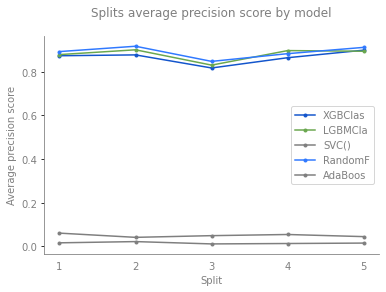

In [19]:
cv_results_splits = cv_results[[col for col in cv_results.columns if "split" in col]]
cv_results_splits.columns = [re.sub("[^0-9]", "", col) if "split" in col else col for col in cv_results_splits.columns]
g = cv_results_splits.T.plot(color = ["#1355cc","#6aa74f","#7f7f7f","#3079FF","#7f7f7f"], style='.-')
plt.title("Splits average precision score by model", pad=20, color="#7f7f7f")
plt.xticks(color="#7f7f7f")
plt.yticks(color="#7f7f7f")
plt.xlabel(None)
plt.xlabel("Split", color="#7f7f7f")
plt.ylabel("Average precision score", color="#7f7f7f")
sns.despine()
legend = plt.legend()
plt.setp(legend.get_texts(), color="#7f7f7f");
g.spines["bottom"].set_color("#7f7f7f")
g.spines["left"].set_color("#7f7f7f")
plt.tick_params(bottom = False)
plt.xticks(range(5),range(1,6));

In [20]:
y_proba = gs.best_estimator_.predict_proba(X_train)[:,1]
y_pred = np.where(y_proba >= 0.5, 1, 0)

In [21]:
print(classification_report(y_train, y_pred, target_names=["good","bad"]))

              precision    recall  f1-score   support

        good       1.00      1.00      1.00     30584
         bad       0.96      0.96      0.96       404

    accuracy                           1.00     30988
   macro avg       0.98      0.98      0.98     30988
weighted avg       1.00      1.00      1.00     30988



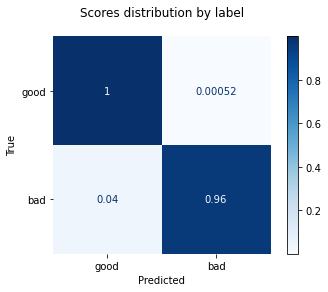

In [22]:
plot_confusion_matrix(gs.best_estimator_, X_train, y_train, normalize="true", display_labels=["good","bad"], cmap="Blues")
plt.title("Normalized confusion matrix", pad=20)
sns.despine(bottom = True, left = True)
plt.title("Scores distribution by label", pad=20, color="black")
plt.xticks(color="black")
plt.yticks(color="black")
plt.ylabel("True", color="black")
plt.xlabel("Predicted", color="black");

## Dump best estimator

In [23]:
with open(f"artifacts/{sts.BEST_ESTIMATOR_FILENAME}","wb") as file:
    pickle.dump(gs.best_estimator_, file)